In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Desktop/Summer_2025/LearningToControlClass/class02`


# The content of this notebook comes from the CMU course "Optimal-Control-16-745" from Zachary Manchester:

https://github.com/Optimal-Control-16-745/lecture-notebooks/blob/main/Lecture%203/root-finding.ipynb

# Part 1 — Root Finding & Backward Euler 
## Goal: Solve r(x_{n+1}) = x_n + h f(x_{n+1}) - x_{n+1} = 0
### • As a fixed point: x_{n+1} = x_n + h f(x_{n+1})
### • Via Newton: solve ∂r Δx = -r with Jacobian ∂r = ∂/∂x [x_n + h f(x) - x]
### • Compare convergence of fixed-point iteration vs. Newton (quadratic) 

In [14]:
using LinearAlgebra
using ForwardDiff
using PyPlot

In [15]:
"""
pendulum_dynamics(x)


Simple undamped pendulum in state-space form x = [θ; θ̇]:


θ̇ = v
v̇ = -(g/ℓ) sin(θ)


Returns the time derivative ẋ = [θ̇; v̇].
"""
function pendulum_dynamics(x)
    l = 1.0
    g = 9.81
    
    θ = x[1]
    θ̇ = x[2]
    
    θ̈ = -(g/l)*sin(θ)
    
    return [θ̇; θ̈]
end

pendulum_dynamics

# Background: Backward Euler via Fixed-Point and Newton

We want one implicit step of Backward Euler:

    x_{n+1} = x_n + h * f(x_{n+1})

Define:

- Residual:  
  r(x) = x_n + h * f(x) - x
- Fixed-point map:  
  g(x) = x_n + h * f(x)

---

**Fixed-point (Picard) iteration**

- Update rule: x_{k+1} = g(x_k)
- Converges locally if the mapping is a contraction:
  - For vectors: spectral radius of (h * J_f) < 1
- The step size h controls stability.
- Damping can help:
  
      x <- (1 - β) * x + β * g(x),   0 < β <= 1

---

**Newton's method**

- Solve the linearized system:

      ∂r * Δx = -r

  where ∂r = d/dx [ x_n + h f(x) - x ]

- Update rule:

      x <- x + Δx

- Near the root, convergence is quadratic (usually fewer iterations than fixed-point).




In [16]:
"""
backward_euler_step_fixed_point(fun, x0, h; tol=1e-8, maxiter=10_000)


Implicit step via **fixed-point iteration** on
x = x0 + h * fun(x).


Converges only if the fixed point is stable and the initial guess lies in its
basin of attraction. Returns `(x_next, errors)`, where `errors[k] = ‖r(x_k)‖` and
r(x) = x0 + h * fun(x) - x.
"""

function backward_euler_step_fixed_point(fun, x0, h)
    xn = x0
    e = [norm(x0 + h.*fun(xn) - xn)]
    while e[end] > 1e-8
        xn = x0 + h.*fun(xn)
        e = [e; norm(x0 + h.*fun(xn) - xn)]
    end
    
    return xn, e
end

backward_euler_step_fixed_point (generic function with 1 method)

In [17]:
"""
backward_euler_step_newton(fun, x0, h; tol=1e-8, maxiter=100)


Implicit step via **Newton's method** on the residual
r(x) = x0 + h * fun(x) - x.


Uses ForwardDiff.jacobian to obtain ∂r/∂x at the current iterate. Quadratic
convergence near the root; typically many fewer iterations than fixed-point.
Returns `(x_next, errors)`.
"""
function backward_euler_step_newton(fun, x0, h)
    xn = x0
    r = x0 + h.*fun(xn) - xn
    e = [norm(r)]
    while e[end] > 1e-8
        ∂r = ForwardDiff.jacobian(x -> x0 + h.*fun(x) - x, xn)
        xn = xn - ∂r\r
        r = x0 + h.*fun(xn) - xn
        e = [e; norm(r)]
    end
    
    return xn, e
end

backward_euler_step_newton

In [18]:
"""
backward_euler_fixed_point(fun, x0, Tf, h)


Integrate using backward Euler where each implicit step is solved by fixed-point
iteration. Returns `(x_hist, t_hist)`.
"""
function backward_euler_fixed_point(fun, x0, Tf, h)
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1], e = backward_euler_step_fixed_point(fun, x_hist[:,k], h)
    end
    
    return x_hist, t
end

backward_euler_fixed_point

In [19]:
"""
backward_euler_newton(fun, x0, Tf, h)


Integrate using backward Euler where each implicit step is solved with Newton.
Returns `(x_hist, t_hist)`.
"""
function backward_euler_newton(fun, x0, Tf, h)
    t = Array(range(0,Tf,step=h))
    
    x_hist = zeros(length(x0),length(t))
    x_hist[:,1] .= x0
    
    for k = 1:(length(t)-1)
        x_hist[:,k+1], e = backward_euler_step_newton(fun, x_hist[:,k], h)
    end
    
    return x_hist, t
end

backward_euler_newton

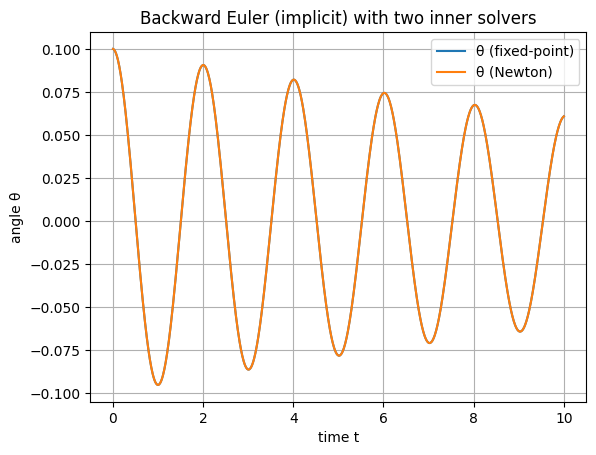

PyObject <matplotlib.legend.Legend object at 0x16a6a3b80>

In [20]:
# --- Demo: compare fixed-point vs Newton for the pendulum ---
x0 = [0.1; 0.0] # small-angle start (near-stable regime)
Tf = 10.0
h = 0.01


x_hist1, t_hist1 = backward_euler_fixed_point(pendulum_dynamics, x0, Tf, h)
x_hist2, t_hist2 = backward_euler_newton(pendulum_dynamics, x0, Tf, h)


figure()
plot(t_hist1, x_hist1[1, :], label="θ (fixed-point)")
plot(t_hist2, x_hist2[1, :], label="θ (Newton)")
xlabel("time t"); ylabel("angle θ"); title("Backward Euler (implicit) with two inner solvers"); grid(true); legend()

In [21]:
# Numerical check that trajectories agree (up to tolerance/roundoff)
maximum(abs.(x_hist1 .- x_hist2))

7.3007510554383426e-6

In [22]:
# --- Single-step convergence histories ---
(xn_fp, e_fp) = backward_euler_step_fixed_point(pendulum_dynamics, x0, 0.1)
(xn_nt, e_nt) = backward_euler_step_newton(pendulum_dynamics, x0, 0.1)

([0.09107763165756541, -0.08922368342434606], [0.09793658173053843, 3.7830087232931797e-6, 5.2874553670659e-15])

In [23]:
e_fp

14-element Vector{Float64}:
 0.09793658173053843
 0.009793658173053846
 0.009564124766684667
 0.0009564124766684723
 0.0009343853483241293
 9.343853483241571e-5
 9.128296581455142e-5
 9.128296581450979e-6
 8.917746787032166e-6
 8.917746786990532e-7
 8.712050176828967e-7
 8.712050177106523e-8
 8.511098474606182e-8
 8.511098478769519e-9

In [24]:
e_nt

3-element Vector{Float64}:
 0.09793658173053843
 3.7830087232931797e-6
 5.2874553670659e-15

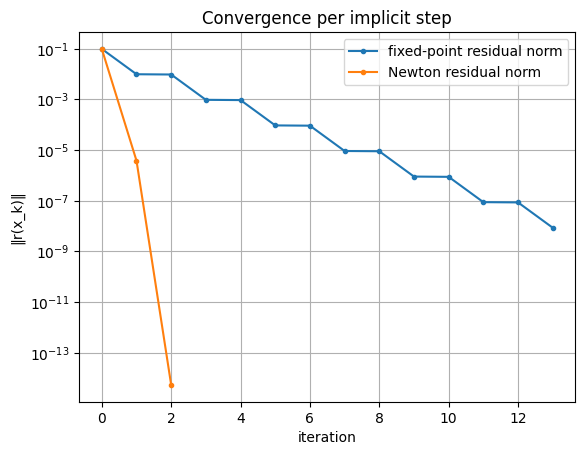

PyObject <matplotlib.legend.Legend object at 0x300e3b700>

In [25]:

figure()
semilogy(e_fp, ".-", label="fixed-point residual norm")
semilogy(e_nt, ".-", label="Newton residual norm")
xlabel("iteration"); ylabel("‖r(x_k)‖"); title("Convergence per implicit step"); grid(true); legend()